### SVMでテキスト分類

In [1]:
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.models import word2vec
import re
import codecs
from sklearn import svm
from gensim import models
import gc
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='talk', style='darkgrid', palette='deep',
        font='IPAexGothic', font_scale=1, color_codes=False, rc=None)

c:\users\shoot\miniconda3\envs\py36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
ID = []
Document = []
for line in open('text/reuter.txt', 'r'):
    itemList = line[:-1].split('\t')
    ID.append(itemList[0])
    Document.append(itemList[1].split())

DIC = {"acq": 0, "crude": 1, "earn": 2, "grain": 3,
       "interest": 4, "money-fx": 5, "ship": 6, "trade": 7}

label = []
for i in ID:
    label.append(DIC[i])

ID = np.array(ID)
Document = np.array(Document)
label = np.array(label)

In [3]:
def normalize(vector):
    X = np.empty((len(vector), len(vector[0])))
    for i, vec in enumerate(vector):
        j = vec / np.linalg.norm(vec)
        X[i] = j
    return X


def shaping(model):
    WORD_dic = {}
    for index, word in enumerate(model.wv.index2word):
        WORD_dic.update({word: index})  # word & index

    I_wei_norm = model.wv.syn0
    O_wei_norm = model.syn1neg
    IO_wei_norm = np.c_[model.wv.syn0, model.syn1neg]
    new_wei_norm = model.wv.syn0 + model.syn1neg
    I_wei_norm = normalize(I_wei_norm)
    O_wei_norm = normalize(O_wei_norm)
    IO_wei_norm = normalize(IO_wei_norm)
    new_wei_norm = normalize(new_wei_norm)

    return I_wei_norm, O_wei_norm, IO_wei_norm, new_wei_norm, WORD_dic

In [4]:
# document2vec
def doc2vec(wei_norm, dim, cut_num, Document):
    W = []
    for i in range(len(Document)):
        A = np.zeros(dim)
        for word in Document[i]:
            try:
                index = WORD_dic[word]
                if 0 <= index < cut_num:  # top occurance cut
                    pass
                else:
                    A = A + wei_norm[index]
            except KeyError:
                pass
        W.append(A)
    W = np.array(W)
    W = normalize(W)
    return W


def evaluate(wei_norm, cut_num, size, C, gamma):
    doc_vec = doc2vec(wei_norm, size, cut_num, X_train)
    clf = svm.SVC(C=C, gamma=gamma, kernel="rbf",
                  probability=False, random_state=0)
    clf.fit(doc_vec, y_train)
    doc_vec_test = doc2vec(wei_norm, size, cut_num, X_test)
    predicted = clf.predict(doc_vec_test)
    score = np.average(predicted == y_test)
    return score


def gen_text():
    wakati = []
    for j in X_train:
        wakati.append(' '.join(j))
    wakati = ' '.join(wakati)
    f = codecs.open('text_reuter.txt', 'w', "utf-8")  # 書き込みモードで開く
    f.write(wakati)  # 引数の文字列をファイルに書き込む
    f.close()

In [7]:
size = 300
window = 5
negative = 5
cut_num = 1
C = 1
gamma = 1
sI = []
sO = []
sconc = []
snew = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for n in range(15):
    print(n+1, "trial")
    scoreI = []
    scoreO = []
    scoreconc = []
    scorenew = []

    for train_index, test_index in kf.split(Document):
        X_train, X_test = Document[train_index], Document[test_index]
        y_train, y_test = label[train_index], label[test_index]
        ID_train, ID_test = ID[train_index], ID[test_index]

        gen_text()
        gc.collect()

        sentences = word2vec.Text8Corpus('text_reuter.txt')
        # learning
        model = word2vec.Word2Vec(sentences, size=size, min_count=5, window=window,
                                  workers=8, sg=1, seed=None, iter=15, negative=negative)

        I_wei_norm, O_wei_norm, IO_wei_norm, new_wei_norm, WORD_dic = shaping(
            model)
        del model
        gc.collect()

        scoreI.append(evaluate(I_wei_norm, cut_num, size, C, gamma))
        scoreO.append(evaluate(O_wei_norm, cut_num, size, C, gamma))
        scoreconc.append(evaluate(IO_wei_norm, cut_num, size*2, C, gamma))
        scorenew.append(evaluate(new_wei_norm, cut_num, size, C, gamma))

        del I_wei_norm, O_wei_norm, IO_wei_norm, new_wei_norm, WORD_dic
        gc.collect()
    print("OUT", np.average(scoreI))
    print("IN", np.average(scoreO))
    print("CONC", np.average(scoreconc))
    print("NEW", np.average(scorenew))
    sI.append(np.average(scoreI))
    sO.append(np.average(scoreO))
    sconc.append(np.average(scoreconc))
    snew.append(np.average(scorenew))

1 trial
OUT 0.962210651933
IN 0.960126046316
CONC 0.961820027265
NEW 0.966380627599
2 trial
OUT 0.962080613584
IN 0.960516670984
CONC 0.961428892975
NEW 0.96598974812
3 trial
OUT 0.961038013496
IN 0.960256254539
CONC 0.961689819042
NEW 0.965729246737
4 trial
OUT 0.961689819042
IN 0.959995498346
CONC 0.961168391593
NEW 0.965989833057
5 trial
OUT 0.962601871159
IN 0.960516586047
CONC 0.961950320424
NEW 0.966380797472
6 trial
OUT 0.961037843623
IN 0.960516670984
CONC 0.961559101198
NEW 0.965077780939
7 trial
OUT 0.961168306656
IN 0.959865290123
CONC 0.960386632635
NEW 0.965859539897
8 trial
OUT 0.960125876442
IN 0.960516925795
CONC 0.961298769689
NEW 0.966511005695
9 trial
OUT 0.961559356009
IN 0.960516501111
CONC 0.961819942328
NEW 0.965989917993
10 trial
OUT 0.962080528647
IN 0.959864865439
CONC 0.961298684753
NEW 0.965468575481
11 trial
OUT 0.961428808038
IN 0.959734742153
CONC 0.961689819042
NEW 0.965468660418
12 trial
OUT 0.961298769689
IN 0.959734657216
CONC 0.9609076354
NEW 0.96625

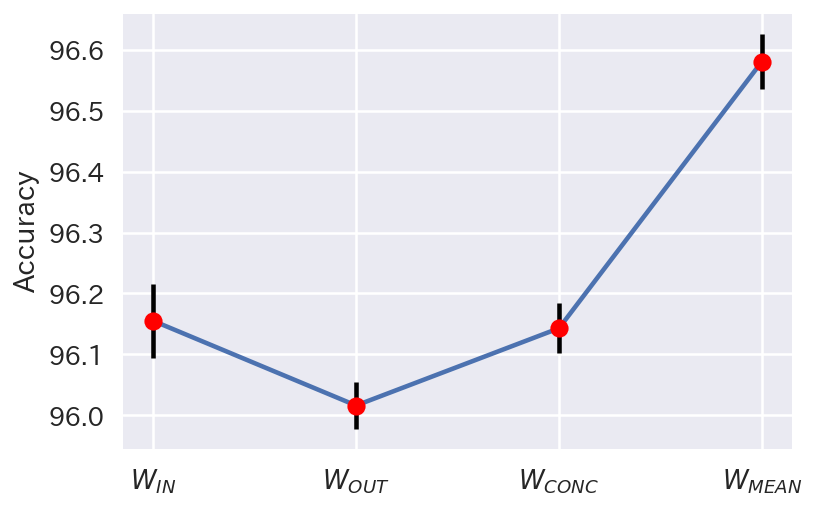

In [9]:
sI = np.array(sI)
sO = np.array(sO)
sconc = np.array(sconc)
snew = np.array(snew)
H = 100

a = np.average(sI*H)
b = np.average(sO*H)
c = np.average(sconc*H)
d = np.average(snew*H)

a_std = np.std(sI*H)
b_std = np.std(sO*H)
c_std = np.std(sconc*H)
d_std = np.std(snew*H)

x = [1,2,3,4]
y = [a,b,c,d]
label = ["$\it{W_{IN}}$", "$\it{W_{OUT}}$", "$\it{W_{CONC}}$", "$\it{W_{MEAN}}$"]
plt.plot(x,y)
plt.xticks(x, label)

# 誤差棒を描画
err = [a_std, b_std, c_std, d_std]
plt.errorbar(x,y,yerr=err,fmt='ro',ecolor='black')

plt.ylabel("Accuracy")
plt.show()